In [1]:
from pyathena.tigress_ncr.ncr_paper_lowz import LowZData

[stellar-intel.princeton.edu:3858634] mca_base_component_repository_open: unable to open mca_op_avx: /usr/local/openmpi/4.1.0/gcc/lib64/openmpi/mca_op_avx.so: undefined symbol: ompi_op_base_module_t_class (ignored)


In [2]:
pdata = LowZData()

LoadSimTIGRESSNCR-WARNING: rst files not found in /scratch/gpfs/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy2048.eps0.0.
LoadSimTIGRESSNCR-WARNING: rst files not found in /scratch/gpfs/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.b10.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0.
LoadSimTIGRESSNCR-WARNING: rst files not found in /scratch/gpfs/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0.
LoadSimTIGRESSNCR-WARNING: rst files not found in /scratch/gpfs/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0.
LoadSimTIGRESSNCR-WARNING: rst files not found in /scratch/gpfs/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.b1.v3.iCR4.Zg1.Zd1.xy2048.eps0.0.
LoadSimTIGRESSNCR-WARNING: rst files not found in /scratch/gpfs/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.b1.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0.
LoadSimTIGRESSNCR-WARNING: rst files not found in /scratch/gpfs/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0.
LoadSimTIGRESSNCR-WARNING: rs

R8-S30 R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps0.0
R8-S30 R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps0.0
R8-b10 R8_8pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy2048.eps0.0
R8-b10 R8_8pc_NCR.full.b10.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0
R8-b10 R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0
R8-b10 R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0
R8-b1 R8_8pc_NCR.full.b1.v3.iCR4.Zg1.Zd1.xy2048.eps0.0
R8-b1 R8_8pc_NCR.full.b1.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0
R8-b1 R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0
R8-b1 R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0
LGR8-S05 LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg1.Zd1.xy4096.eps0.0
LGR8-S05 LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg0.1.Zd0.1.xy8192.eps0.0
LGR4-S100 LGR4_4pc_NCR_S100.full.b1.v3.iCR5.Zg1.Zd1.xy1024.eps1.e-8.rstZ01
LGR4-S100 LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8
LGR4-S100 LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps1.e-8
LGR4-b10 LGR4_4pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy10

In [3]:
s = pdata.sa.set_model(pdata.mlist[0])

In [4]:
for gr in ['R8','LGR4']:
    for m in sorted(pdata.mgroup[gr])[::-1]:
        s = pdata.sa.set_model(m)
        if hasattr(s,'zp_ph'): continue
        zp = s.read_zprof_new(flist=['A','d'])
        shorthands = s.get_phase_shorthand()
        rename_dict=dict()
        for i,pname in enumerate(shorthands):
            rename_dict['phase{}'.format(i+1)] = pname
        zp = zp.to_array().to_dataset('phase').rename(rename_dict)
        torb = s.torb_Myr
        if s.torb_Myr <50:
            trange = slice(torb*5,torb*15)
        elif s.torb_Myr >300:
            trange = slice(torb*1.5,torb*5)
        else:
            trange = slice(torb*2,torb*5)
        zp = zp.to_array('phase').to_dataset('variable').sel(z=slice(-300,300),time=trange)
        zpw = zp.sel(phase=['c','u','w1','w2','h1','h2']).sum(dim='phase')
        zp_Cold = zp.sel(phase=['cmm','cnm']).sum(dim='phase')
        zp_UNM = zp.sel(phase=['unm']).sum(dim='phase')
        zp_WNM = zp.sel(phase=['wnm']).sum(dim='phase')
        zp_WIM = zp.sel(phase=['uim','wpim','wcim']).sum(dim='phase')
        zp_HIM = zp.sel(phase=['h1','h2']).sum(dim='phase')
        zp_ph = xr.concat([zp_Cold.assign_coords(phase=['CNM']),
                        zp_UNM.assign_coords(phase=['UNM']),
                        zp_WNM.assign_coords(phase=['WNM']),
                        zp_WIM.assign_coords(phase=['WIM']),
                        zp_HIM.assign_coords(phase=['HIM'])],dim='phase')
        s.zp_ph = zp_ph
        s.zpw = zpw

In [ ]:
plt.style.use('presentation-dark.mplstyle')

In [ ]:
outdir = '../lowZ-figures-talk/'

In [ ]:
mgroup='LGR4'

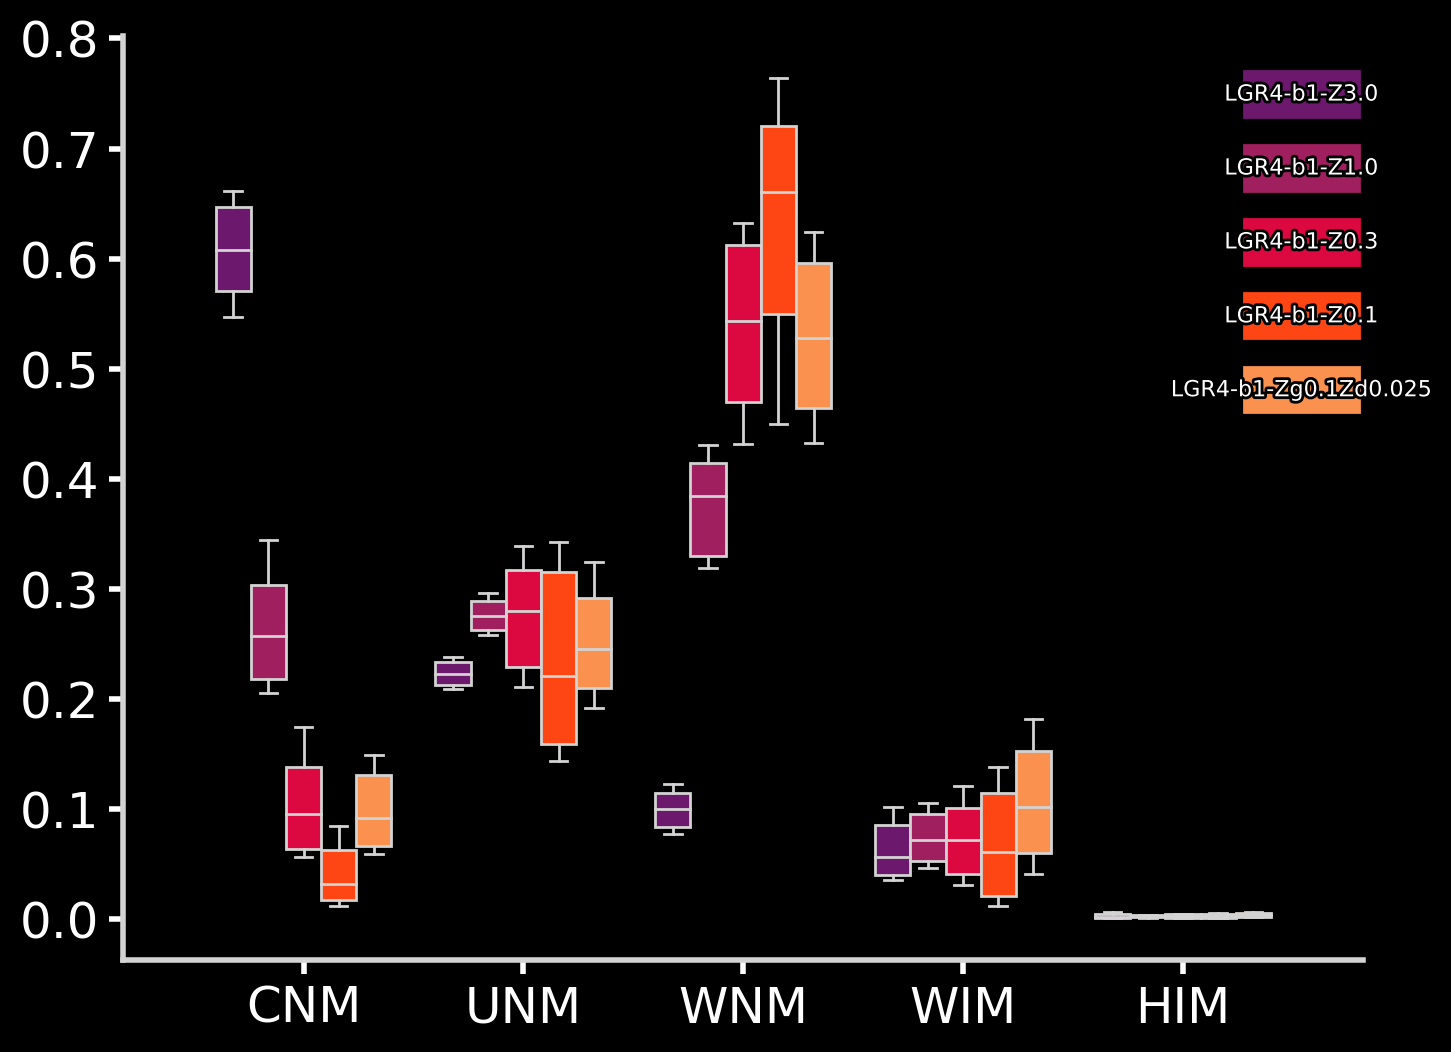

In [ ]:
from pyathena.plt_tools.utils import texteffect

mlist = pdata.mgroup[mgroup]
mlist = sorted(mlist)[::-1]
nmodel = len(mlist)
w = 0.8/nmodel
offset = np.arange(nmodel+1)/nmodel*0.8-0.4 + 0.5*w
edge_color = plt.rcParams['axes.edgecolor']
legend=True
for i,m in enumerate(mlist):
    s = pdata.sa.set_model(m)
    zp_ph = s.zp_ph
    zpw = s.zpw
    volume=(zp_ph['A'].sum(dim='z')/zpw['A'].sum(dim='z'))
    mass=(zp_ph['d'].sum(dim='z')/zpw['d'].sum(dim='z'))
    plist = list(mass['phase'].data)
    box=plt.boxplot(mass.data.T,positions=np.arange(len(plist))+offset[i],widths=w,
                    whis=[16,84],showfliers=False,
                    patch_artist=True,medianprops=dict(color=edge_color),
    #                         showmeans=True,
    #                         meanprops=dict(markerfacecolor='tab:orange',markeredgecolor='w',
    #                                        markersize=5,markeredgewidth=0.5,
    #                                        marker='*')
                    )
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(box[element], color=edge_color)
    plt.setp(box['boxes'],'facecolor',s.color)
    plt.xticks(ticks=np.arange(len(plist)),labels=plist)
    if legend:
        x0=0.95
        dx=0.015
        y0=0.95
        dy=0.08

        c = s.color
        plt.annotate('             ',(x0,y0-dy*i),xycoords='axes fraction',
                        ha='center',va='top',size=8,
                        backgroundcolor=c,color=c)
        plt.annotate(s.name,(x0,y0-dy*i),xycoords='axes fraction',
                        ha='center',va='top',**texteffect(8,linewidth=2, foreground=plt.rcParams['axes.facecolor']))


In [ ]:
from pyathena.plt_tools.utils import texteffect
def plot_box_phase(mgroup,field='A'):
    mlist = pdata.mgroup[mgroup]
    mlist = sorted(mlist)[::-1]
    nmodel = len(mlist)
    w = 0.8/nmodel
    offset = np.arange(nmodel+1)/nmodel*0.8-0.4 + 0.5*w
    edge_color = plt.rcParams['axes.edgecolor']
    legend=True
    for i,m in enumerate(mlist):
        s = pdata.sa.set_model(m)
        zp_ph = s.zp_ph
        zpw = s.zpw
        data = (zp_ph[field].sum(dim='z')/zpw[field].sum(dim='z'))
        plist = list(mass['phase'].data)
        box=plt.boxplot(data.data.T,positions=np.arange(len(plist))+offset[i],widths=w,
                        whis=[16,84],showfliers=False,
                        patch_artist=True,medianprops=dict(color=edge_color),
        #                         showmeans=True,
        #                         meanprops=dict(markerfacecolor='tab:orange',markeredgecolor='w',
        #                                        markersize=5,markeredgewidth=0.5,
        #                                        marker='*')
                        )
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(box[element], color=edge_color)
        plt.setp(box['boxes'],'facecolor',s.color)
        plt.xticks(ticks=np.arange(len(plist)),labels=plist)
        if legend:
            x0=0.90
            dx=0.05
            y0=0.95
            dy=0.08

            c = s.color
            plt.annotate('                           ',(x0,y0-dy*i),xycoords='axes fraction',
                            ha='center',va='top',size=8,
                            backgroundcolor=c,color=c)
            plt.annotate(pdata.get_model_name(s,beta=False),(x0,y0-dy*i),xycoords='axes fraction',
                            ha='center',va='top',**texteffect(8,linewidth=2, foreground=plt.rcParams['axes.facecolor']))
        plt.ylim(0,0.8)
        if field == 'A': plt.ylabel('Volume Fraction')
        elif field == 'd': plt.ylabel('Mass Fraction')


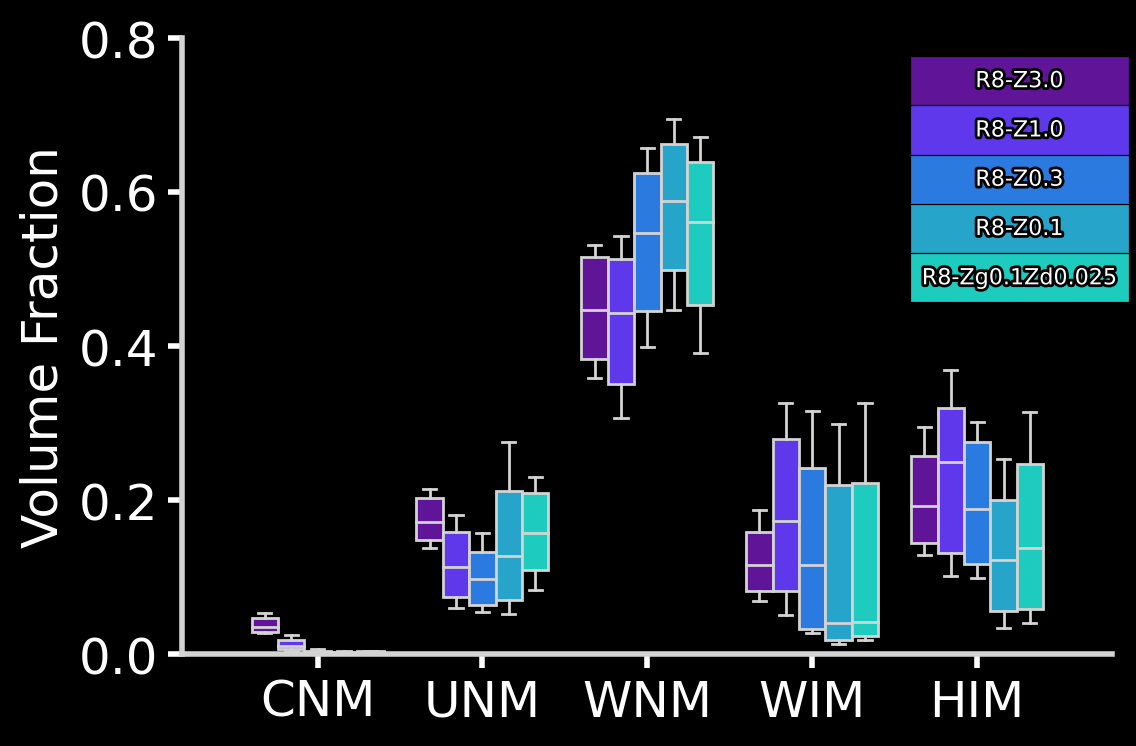

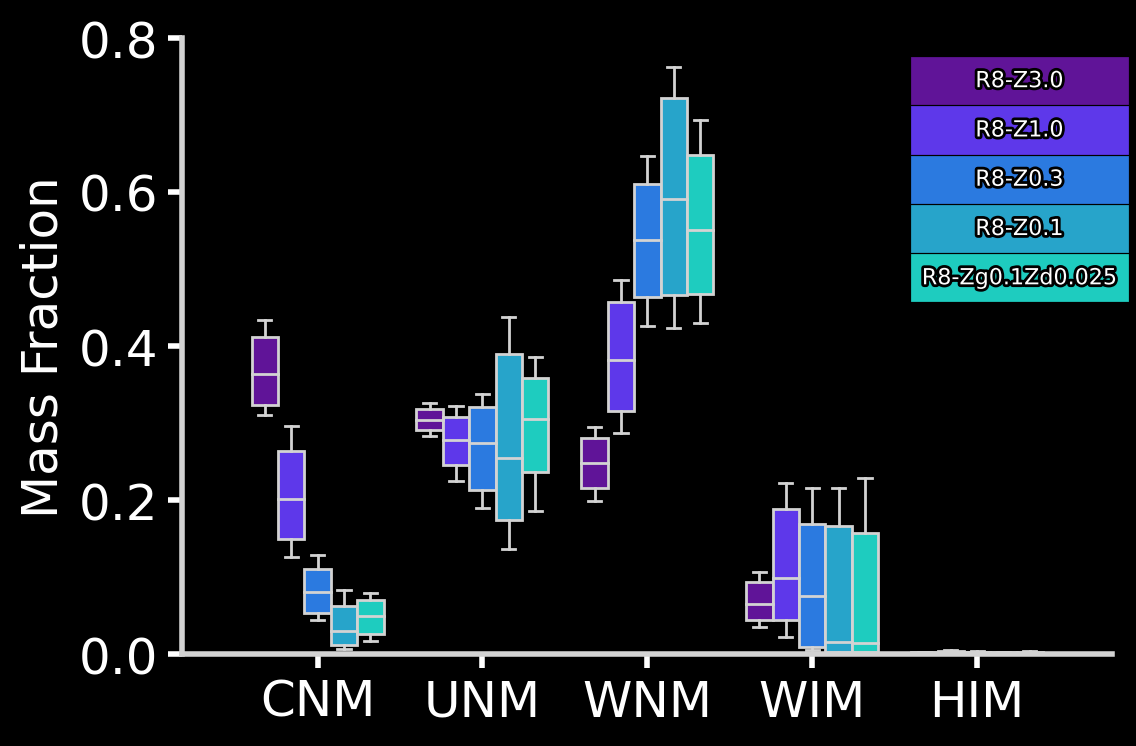

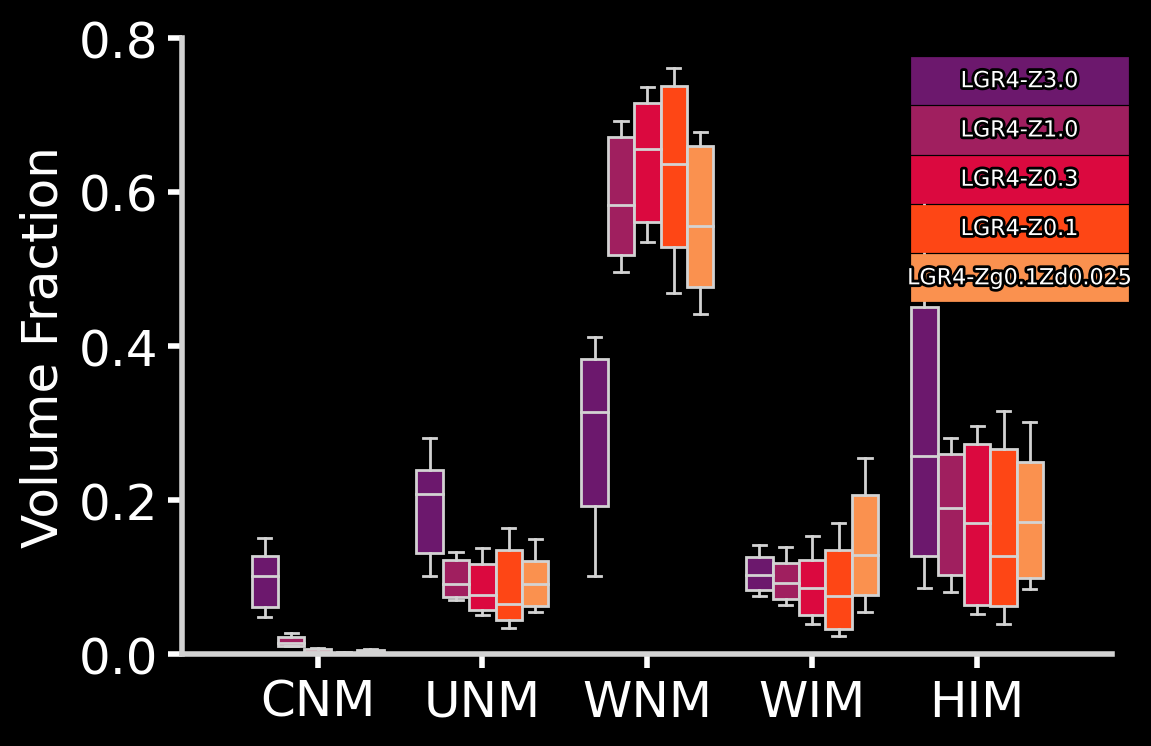

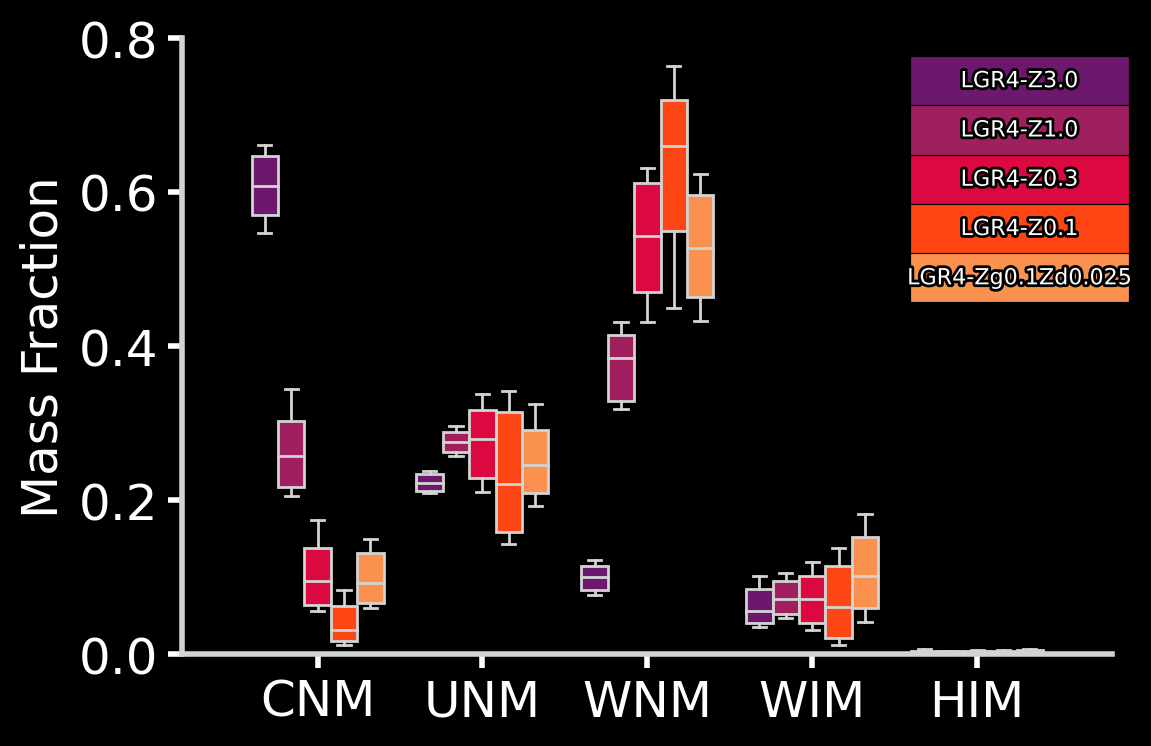

In [ ]:
for mg in ['R8','LGR4']:
    for field in ['A','d']:
        plt.figure(figsize=(6,4))
        plot_box_phase(mg,field)
        plt.savefig(os.path.join(outdir,f'{mg}-{field}.png'),bbox_inches='tight')